In [1]:
import numpy as np
import pandas as pd
import altair as alt
from scipy.stats import binned_statistic_2d

alt.data_transformers.enable('default', max_rows=None)
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

### Load Profiling Data of Database App

The database application is part of the project of our DBMS core lecture.

In [2]:
dt = np.dtype([('TSC', 'uint64'), ('Address', 'uint64'), ('Operation', 'int8')])
data = np.fromfile("dbms.bin", dtype=dt)
df = pd.DataFrame(data.tolist(), columns=data.dtype.names)

### Subsample Profiling Data for Plotting

In [3]:
df_dbms = df[::1000].copy()
df_dbms['Operation'] = df_dbms['Operation'].apply(chr)
df_dbms['Address'] = df_dbms['Address'].apply(hex)
df_dbms['TSC'] = df_dbms['TSC'] - min(df['TSC'])
df_dbms['Time'] = df_dbms['TSC'] / 2.6e9
df_dbms['is_read'] = df_dbms['Operation'] == 'R'
df_dbms['is_write'] = df_dbms['Operation'] == 'W'
display(df_dbms.head(10))
display(df_dbms.shape)

TSC         Address Operation      Time  is_read  is_write
0              0  0x7f1e7696ade8         R  0.000000     True     False
1000   606538994  0x7ffe1b0aee78         R  0.233284     True     False
2000  1650260660  0x7ffe1b0ae500         R  0.634716     True     False
3000  1708900118  0x7ffe1b0ae6e0         R  0.657269     True     False
4000  1721655684  0x563d841b658a         R  0.662175     True     False
5000  1731289458  0x7ffe1b0ae4a4         R  0.665881     True     False
6000  1738875666  0x563d841b5bc0         R  0.668798     True     False
7000  1748710840  0x563d841b5c98         R  0.672581     True     False
8000  1760916708  0x563d841fa161         W  0.677276    False      True
9000  1767955404  0x7ffe1b0ae420         W  0.679983    False      True

(8146, 6)

### Plot the Profiling Data

Note that you can select a horizontal range in the upper plot and the lower plot will dynamically adapt to that range.  Further, the selected range can be moved sidewards.

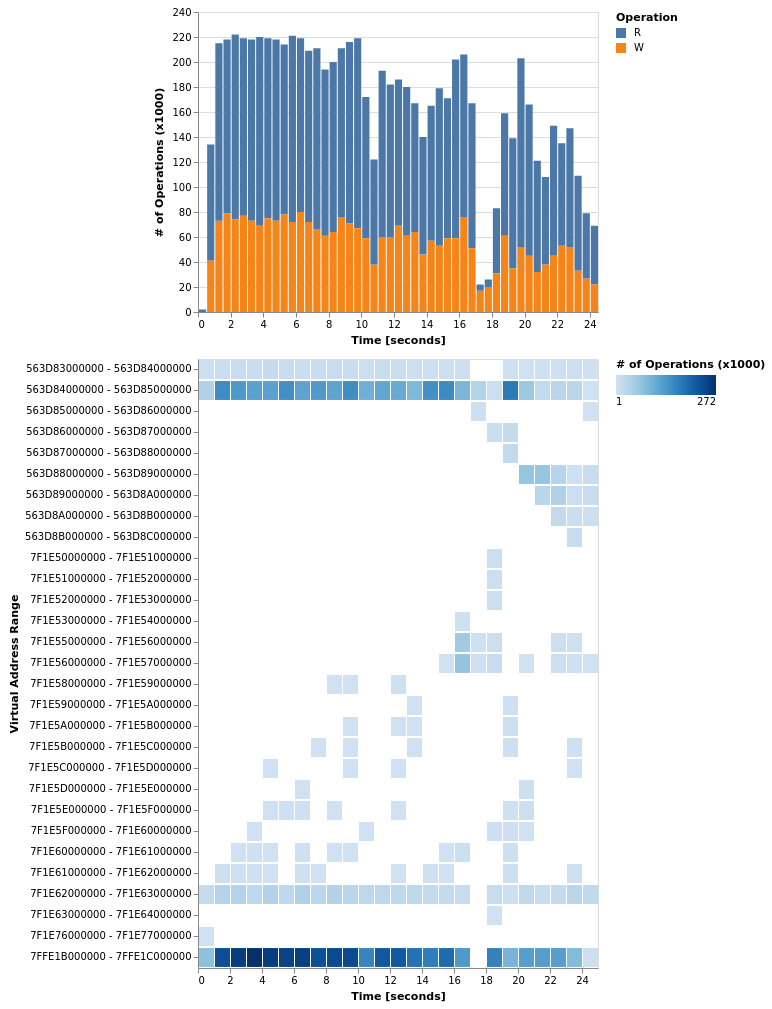

In [4]:
interval = alt.selection_interval(encodings=['x'])

time_chart = alt.Chart(df_dbms).mark_bar().encode(
    x = alt.X('Time', bin=alt.Bin(step=.5), axis=alt.Axis(title='Time [seconds]')),
    y = alt.Y('count()', axis=alt.Axis(title='# of Operations (x1000)')),
    color = 'Operation',
    tooltip = 'count()',
).properties(
    selection=interval
)

activity_heatmap = alt.Chart(df_dbms).mark_bar().encode(
    x = alt.X('Time', bin=alt.Bin(maxbins=25), axis=alt.Axis(title='Time [seconds]')),
    y = alt.Y('Address', bin=alt.Bin(step=4096*2**12), axis=alt.Axis(format='0X', title='Virtual Address Range')),
    color = alt.Color('count()', title='# of Operations (x1000)'),
).transform_filter(
    interval
)

activity_heatmap.encoding.tooltip = [
    {"type": "quantitative", "aggregate": "sum", "field": "is_read", "title": "reads"},
    {"type": "quantitative", "aggregate": "sum", "field": "is_write", "title": "writes"}
]

time_chart & activity_heatmap

### Load Profiling Data of Intel Embree

We ran the Intel Embree Path Tracer on the crown demo.

In [5]:
dt = np.dtype([('TSC', 'uint64'), ('Address', 'uint64'), ('Operation', 'int8')])
data = np.fromfile("embree.bin", dtype=dt)
df = pd.DataFrame(data.tolist(), columns=data.dtype.names)

### Subsample Profiling Data for Plotting

In [6]:
df_embree = df[::1000].copy()
df_embree['Operation'] = df_embree['Operation'].apply(chr)
df_embree['Address'] = df_embree['Address'].apply(hex)
df_embree['TSC'] = df_embree['TSC'] - min(df['TSC'])
df_embree['Time'] = df_embree['TSC'] / 2.6e9
df_embree['is_read'] = df_embree['Operation'] == 'R'
df_embree['is_write'] = df_embree['Operation'] == 'W'
display(df_embree.head(10))
display(df_embree.shape)

TSC         Address Operation      Time  is_read  is_write
0              0  0x7f4a1e3bede8         R  0.000000     True     False
1000   727958814  0x7f4a073dd9dc         R  0.279984     True     False
2000   757516674  0x7ffe54afeba8         R  0.291353     True     False
3000   793301608  0x7ffe54afeb40         R  0.305116     True     False
4000   799124782  0x7ffe54afec40         W  0.307356    False      True
5000   809301618  0x7ffe54afebd8         R  0.311270     True     False
6000   820723318  0x7f4a091802ec         R  0.315663     True     False
7000   851554790  0x7ffe54afeb10         W  0.327521    False      True
8000  4014034198  0x7ffe54afe408         R  1.543859     True     False
9000  6025596222  0x7ffe54afe650         R  2.317537     True     False

(14218, 6)

### Plot the Profiling Data

Note that you can select a horizontal range in the upper plot and the lower plot will dynamically adapt to that range.  Further, the selected range can be moved sidewards.

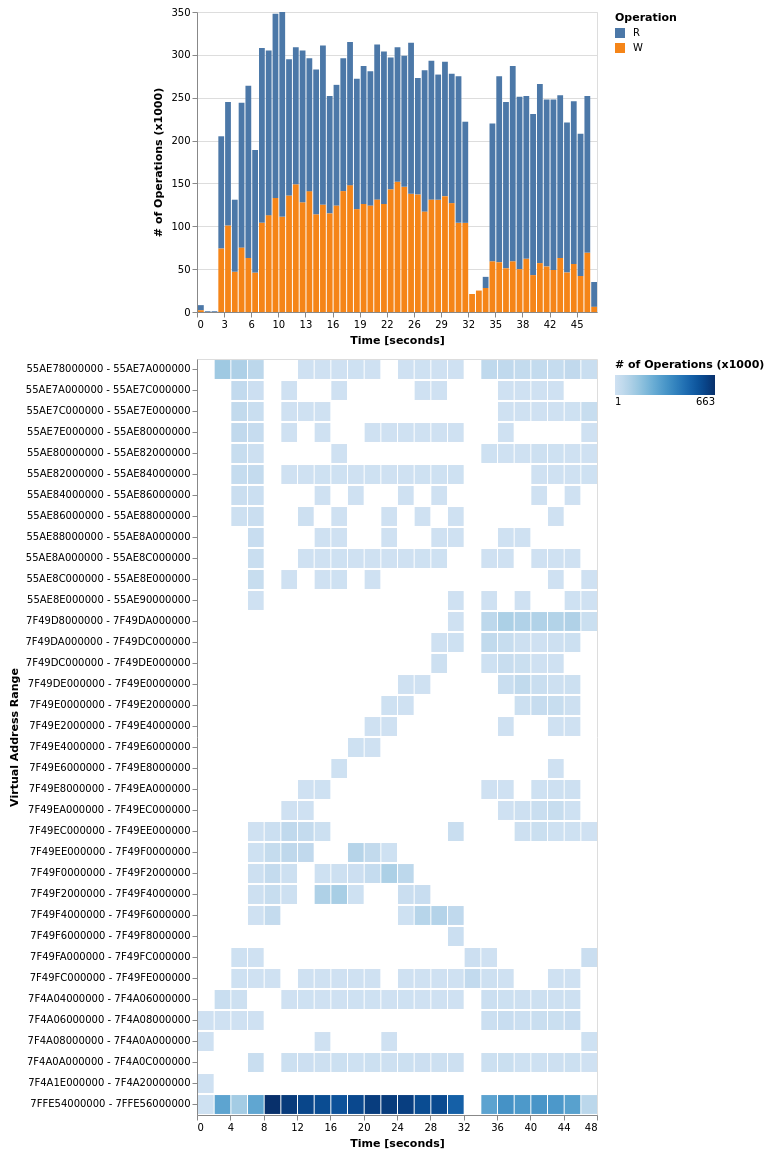

In [7]:
interval = alt.selection_interval(encodings=['x'])

time_chart = alt.Chart(df_embree).mark_bar().encode(
    x = alt.X('Time', bin=alt.Bin(step=.8), axis=alt.Axis(title='Time [seconds]')),
    y = alt.Y('count()', axis=alt.Axis(title='# of Operations (x1000)')),
    color = 'Operation',
    tooltip = 'count()',
).properties(
    selection=interval
)

activity_heatmap = alt.Chart(df_embree).mark_bar().encode(
    x = alt.X('Time', bin=alt.Bin(maxbins=25), axis=alt.Axis(title='Time [seconds]')),
    y = alt.Y('Address', bin=alt.Bin(step=4096*2**13), axis=alt.Axis(format='0X', title='Virtual Address Range')),
    color = alt.Color('count()', title='# of Operations (x1000)'),
    tooltip = 'count()',
).transform_filter(
    interval
).interactive()

activity_heatmap.encoding.tooltip = [
    {"type": "quantitative", "aggregate": "sum", "field": "is_read", "title": "reads"},
    {"type": "quantitative", "aggregate": "sum", "field": "is_write", "title": "writes"}
]

time_chart & activity_heatmap

In [9]:
df_embree['PageId'] = (df_embree['Address'].apply(int, base=16) / 4096).apply(int)
display(df_embree.head())

TSC         Address Operation      Time  is_read  is_write  \
0             0  0x7f4a1e3bede8         R  0.000000     True     False   
1000  727958814  0x7f4a073dd9dc         R  0.279984     True     False   
2000  757516674  0x7ffe54afeba8         R  0.291353     True     False   
3000  793301608  0x7ffe54afeb40         R  0.305116     True     False   
4000  799124782  0x7ffe54afec40         W  0.307356    False      True   

           PageId  
0     34169021374  
1000  34168927197  
2000  34357988094  
3000  34357988094  
4000  34357988094

In [53]:
bins = np.linspace(0, df_embree['Time'].max(), 200)
groups = df_embree.groupby(pd.cut(df_embree['Time'], bins, right=False, include_lowest=True))
df_embree_binned = pd.DataFrame(data = {
    'Time': bins[0:-1],
    'num_pages': groups['PageId'].nunique(),
    'num_io': groups['PageId'].count()
})
display(df_embree_binned.head(25))

Time  num_pages  num_io
Time                                       
[0.0, 0.235)    0.000000          1       1
[0.235, 0.47)   0.235130          3       7
[0.47, 0.705)   0.470260          0       0
[0.705, 0.941)  0.705389          0       0
[0.941, 1.176)  0.940519          0       0
[1.176, 1.411)  1.175649          0       0
[1.411, 1.646)  1.410779          1       1
[1.646, 1.881)  1.645909          0       0
[1.881, 2.116)  1.881039          0       0
[2.116, 2.351)  2.116168          1       1
[2.351, 2.586)  2.351298          0       0
[2.586, 2.822)  2.586428          8      66
[2.822, 3.057)  2.821558         11      86
[3.057, 3.292)  3.056688         10      86
[3.292, 3.527)  3.291818         11      86
[3.527, 3.762)  3.526947         10      53
[3.762, 3.997)  3.762077         10      72
[3.997, 4.232)  3.997207          9      69
[4.232, 4.467)  4.232337          8      51
[4.467, 4.703)  4.467467          4      10
[4.703, 4.938)  4.702597         38      40
[4.938, 5.173)  4.937726         51      67
[5.173, 5.408)  5.172856         66      76
[5.408, 5.643)  5.407986         65      77
[5.643, 5.878)  5.643116         44      54

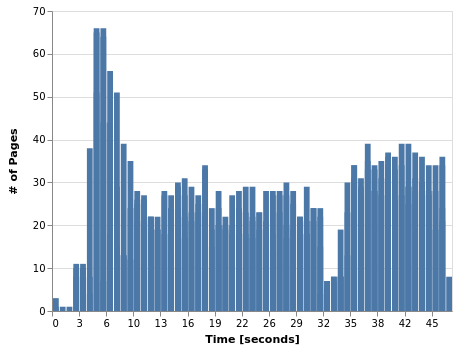

In [54]:
time_page_chart = alt.Chart(df_embree_binned).mark_bar().encode(
    x = alt.X('Time', bin=alt.Bin(step=.8), axis=alt.Axis(title='Time [seconds]')),
    y = alt.Y('num_pages', axis=alt.Axis(title='# of Pages')),
    tooltip = 'num_io',
)

time_page_chart